In [1]:
# %load ../edp_2d.py
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
from scipy.sparse.linalg import bicgstab, bicg, cg, cgs, gmres, lgmres, minres, qmr, gcrotmk
import matplotlib.animation as animation
from IPython.display import HTML

import time
start_time = time.time()

#Coéfficients physiques
K=.4 #coefficient diffusion
b=.2# dtC=-b*rho*C
F0= 1 # dtRho = Fo*Mu

physique = [K,b,F0]

#Paramêtres numériques 
n_t=500 #nombre de pas de temps
tf=140 # temps final de la simulation
xf = 500 #longueur de la simulation
n_x = 400 #nombres de points de la simulation
yf = xf
n_y = n_x 
n_xy = n_x * n_y
numerique = [n_t,tf,xf,n_x,yf,n_y]

params = physique,numerique


#Données initiales 
rho0=np.zeros(n_xy) #rho initial	
mu0=np.zeros(n_xy)#mu initial
mu0[((n_xy+n_x)//2):((n_xy+n_x)//2)+1]=.01
c0=np.zeros(n_xy) +1 #concentration initiale

xm = 200
xM = 300
ym = 120
yM = 220
im = ((xm*n_x)//xf)
iM = ((xM*n_x)//xf)
jm = ((ym*n_y)//xf)
jM = ((yM*n_y)//xf)
for i in range(im,iM):
    for j in range(jm,jM):
        c0[i+j*n_x] = 0.
        
class EDP():
    def __init__(self,params):
        self.physique, self.numerique = params
        self.K,self.b,self.F0 = self.physique
        self.n_t,self.tf,self.xf,self.n_x,self.yf,self.n_y = self.numerique
        
        
        self.n_xy = self.n_x*self.n_y
        self.dt = self.tf/(self.n_t-1)
        self.dx = self.xf/(self.n_x-1)
        self.dy = self.yf/(self.n_y-1)
        
        #self.X = np.linspace(0,self.xf,self.n_x)
        #self.Y = np.linspace(0,self.yf,self.n_y)
        #self.T = np.linspace(0,self.tf,self.n_t)

        #Matrice du Laplacien
        self.Lapl = sp.diags(-4*np.ones(self.n_xy),0)
        #Lapl += sp.diags(np.ones(n_xy-1),1)+sp.diags(np.ones(n_xy-1),-1)
        diagmod = np.ones(self.n_xy-1)
        diagmod[np.arange(self.n_y-1,self.n_xy-1,self.n_y)] = np.zeros(self.n_y-1)
        self.Lapl += sp.diags(diagmod,1) + sp.diags(diagmod,-1)
        self.Lapl += sp.diags(np.ones(self.n_xy-self.n_y),self.n_y)+sp.diags(np.ones(self.n_xy-self.n_y),-self.n_y)
        self.Lapl = -self.K*self.dt/(self.dx**2)*self.Lapl
        self.Cond = sp.identity(self.n_xy)
    def array_to_2D(n_x,vect):
        return np.array(np.split(vect,n_x))

    def integrate(self,initial):
        mu,rho,c = initial
        alpha=-c*self.dt*(1+self.dt*self.F0)+self.dt*rho+1
        A = self.Lapl + sp.diags(alpha,0)
        Target =  mu+self.dt*c*rho
        
        #next_mu = spsolve(A,Target) #95.28 secondes d'execution
        #next_mu,check = bicg(A,Target) #3.38 secondes d'execution
        #next_mu,check = bicgstab(A,Target, x0=mu) #2.15 secondes d'execution
        #next_mu,check = cg(A,Target) #2.29 secondes d'execution
        #next_mu,check = cgs(A,Target) #2.36 secondes d'execution
        #next_mu,check = gmres(A,Target) #2.72 secondes d'execution
        #next_mu,check = lgmres(A,Target) #2.62 secondes d'execution
        next_mu,check = minres(A,Target, x0=mu, M=self.Cond) #2.15 secondes d'execution
        #next_mu,check = qmr(A,Target) #3.70 secondes d'execution
        #next_mu,check = gcrotmk(A,Target) #2.62 secondes d'execution
        next_rho = rho + self.dt*self.F0*next_mu
        next_c = c/(1+self.b*self.dt*next_rho)
        return next_mu, next_rho, next_c
        
        
Agent = EDP(params)

mu= mu0
rho= rho0
c= c0
Mu=[mu0]
Rho=[rho0]
C=[c0]
n = 0
step = 5
while n<n_t:
    mu,rho,c = Agent.integrate((mu,rho,c)) 
    if n % step ==0 :
        Mu.append(mu)
        Rho.append(rho)
        C.append(c)
    if n % 25 ==0 :
        print(n, (time.time() - start_time))
    n+=1

print("--- %s seconds ---" % (time.time() - start_time))

tot = len(Mu)

# Draw = 'C' 
# f = C
  
# fig = plt.figure()    
# im = plt.imshow(EDP.array_to_2D(n_x,f[2]), animated=True, cmap ='PiYG')

# i = 2
# def updatefig(*args):
#     global i
#     i+=1
#     if i< tot -1:
#         im.set_array(EDP.array_to_2D(n_x,f[i]))
#     return im,

# ani = animation.FuncAnimation(fig, updatefig, interval=100, blit=True, repeat=True)
# ani.save('EDP_2D_'+Draw+'.gif',writer='imagemagick', fps=30)

# Draw = 'Mu' 
# f = Mu
  
# fig = plt.figure()    
# im = plt.imshow(EDP.array_to_2D(n_x,f[2]), animated=True, cmap ='PiYG')

# i = 2
# def updatefig(*args):
#     global i
#     i+=1
#     if i< tot -1:
#         im.set_array(EDP.array_to_2D(n_x,f[i]))
#     return im,

# ani = animation.FuncAnimation(fig, updatefig, interval=100, blit=True, repeat=True)
# ani.save('EDP_2D_'+Draw+'.gif',writer='imagemagick', fps=30)


# Draw = 'Rho' 
# f = Rho
  
# fig = plt.figure()    
# im = plt.imshow(EDP.array_to_2D(n_x,f[2]), animated=True, cmap ='PiYG')

# i = 2
# def updatefig(*args):
#     global i
#     i+=1
#     if i< tot -1:
#         im.set_array(EDP.array_to_2D(n_x,f[i]))
#     return im,

# ani = animation.FuncAnimation(fig, updatefig, interval=100, blit=True, repeat=True)
# ani.save('EDP_2D_'+Draw+'.gif',writer='imagemagick', fps=30)


# plt.show()


0 0.12088990211486816
25 1.006584882736206
50 1.7592267990112305
75 2.857285976409912
100 3.9393975734710693
125 4.909400939941406
150 5.679736137390137
175 6.3914453983306885
200 7.1211841106414795
225 7.8345654010772705
250 8.52890396118164
275 9.221187353134155
300 9.944642782211304
325 10.669846296310425
350 11.381176710128784
375 12.083619832992554
400 12.80394697189331
425 13.505017518997192
450 14.204456090927124
475 14.902800559997559
--- 15.641382217407227 seconds ---


In [2]:
fps = 10 # frame per sec
frn = tot # frame number of the animation

X = np.linspace(0,xf,n_x)
x, y = np.meshgrid(X, X)
muarray = np.zeros((n_x, n_x, frn))
rhoarray =  np.zeros((n_x, n_x, frn))

f = lambda x,y,sig : 1/np.sqrt(sig)*np.exp(-(x**2+y**2)/sig**2)

for i in range(frn):
    muarray[:,:,i] = EDP.array_to_2D(n_x,Mu[i])
    rhoarray[:,:,i] =  EDP.array_to_2D(n_x,Rho[i])

In [4]:
import numpy as np
print('numpy: '+np.version.full_version)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib
print('matplotlib: '+matplotlib.__version__)

numpy: 1.16.3
matplotlib: 2.1.1


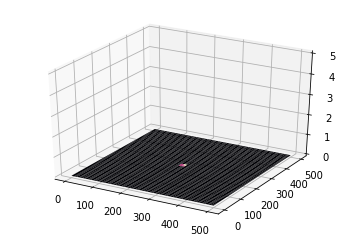

In [5]:
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(x, y, zarray[:,:,frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(x, y, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,2)
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)

In [6]:
HTML(ani.to_jshtml())

In [ ]:
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(x, y, zarray[:,:,frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(x, y, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,5)
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)